<a href="https://colab.research.google.com/github/nyquist/aoe2de/blob/main/AOE2DE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Config Replay

In [1]:
#game_id = "358345344" #"357732557"

Get latest match ids

In [2]:
import requests
import os
#profile_id = "18446743"
#relic_id = "222475" #nyquist
relic_id = "243000" #gabisan
#match_type = 4
#game = "age2"

#profile_url = f"https://www.ageofempires.com/stats/?profileId={profile_id}&game={game}&matchType={match_type}"
profile_url = f"https://www.aoe2insights.com/user/{relic_id}/matches/"
response = requests.get(profile_url)
#print (response.status_code)
#print (response.headers)
import re
matches = re.finditer(r'href="/match/(\d+)/"', response.text)
games = []
for match in matches:
    found_game_id = match.group(1)
    games.append(found_game_id)
game_id = games[0]
print (game_id)
new_game = False
if os.path.exists("last_game.txt"):
  with open("last_game.txt", "r") as f:
    last_game = f.read()
    print ("Last Game",last_game)
    print ("Current Game", game_id)
    if last_game != game_id:
      new_game = True
else:
  new_game = True

with open("last_game.txt", "w") as f:
  f.write(game_id)





358783598


#Environment Setup

In [3]:
! [[ -d "aoe2de" ]] && (cd aoe2de && git pull) || git clone https://github.com/nyquist/aoe2de.git
#! cd aoe2de &&  git branch --set-upstream-to=origin/refactor2 refactor2 && git checkout refactor2
! cd aoe2de && git pull
! ls -la ./aoe2de/utils
! tail aoe2de/mtmExtractBuildingsfromJson.py

Cloning into 'aoe2de'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 141 (delta 82), reused 45 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (141/141), 2.04 MiB | 3.10 MiB/s, done.
Resolving deltas: 100% (82/82), done.
Already up to date.
total 12
drwxr-xr-x 2 root root 4096 Dec 16 22:23 .
drwxr-xr-x 4 root root 4096 Dec 16 22:23 ..
-rw-r--r-- 1 root root   22 Dec 16 22:23 test.py
        description='Extracts Players from JSON')
    parser.add_argument('filename')           # positional argument
    args = parser.parse_args()

    inputFile = args.filename    
    analyzer = BuildingsAnalyzer(inputFile)
    for t in analyzer.getTables(byTeam = True, rows = 3):
        print (len(t))
        print (t)
    print(analyzer.getValues())


In [4]:
import os

def list_files_with_dynamic_sizes(path="."):
    """Lists all files and their sizes with dynamic units (B, kB, MB, etc.) in the given directory.

    Args:
        path (str, optional): The directory path to list files from. Defaults to "." (current directory).
    """
    for entry in os.scandir(path):
        if entry.is_file():
            file_size = os.path.getsize(entry.path)
            unit_index = 0
            units = ["B", "kB", "MB", "GB", "TB"]
            while file_size >= 1024 and unit_index < len(units) - 1:
                file_size /= 1024
                unit_index += 1
            print(f"{entry.name}: {file_size:.2f} {units[unit_index]}")

# Call the function to list files and sizes with dynamic units in the current directory


# Download record

In [5]:
import requests

replay_url = f"https://aoe.ms/replay/?gameId={game_id}&profileId=18446743"  # Replace with the actual URL you copied

response = requests.get(replay_url)
response.raise_for_status()  # Raise an exception for bad responses
print (response.status_code)
content_disposition = response.headers['Content-Disposition']
import re
match = re.search(r'filename="?([^";]+)"?', content_disposition)
if match:
    file_name = match.group(1)
    print(f"Extracted filename: {file_name}")
    with open(file_name, "wb") as f:
      f.write(response.content)
else:
    print("Filename not found in Content-Disposition header.")


print(f"Replay file downloaded as {file_name}")
#list_files_with_dynamic_sizes()





200
Extracted filename: AgeIIDE_Replay_358783598.zip
Replay file downloaded as AgeIIDE_Replay_358783598.zip


### Unzip record file

In [6]:
zip_file_name = file_name
record_file_name = file_name.replace(".zip", ".aoe2record")

import zipfile
import os

try:
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        zip_ref.extractall(".")  # Extract all files to the current directory
    print(f"Successfully extracted files from {zip_file_name}")

    # Find the extracted replay file (assuming it's an .mgz file)
    extracted_file_name = None
    for filename in os.listdir("."):
        print (filename)
        if filename == record_file_name:
            extracted_file_name = filename
            break

    if extracted_file_name:
        # Process the extracted replay file
        print ("Extracted file:", extracted_file_name)
    else:
        print("Error: Could not find extracted replay file (.mgz).")

except zipfile.BadZipFile:
    print(f"Error: {zip_file_name} is not a valid zip file.")
except FileNotFoundError:
    print(f"Error: {zip_file_name} not found.")
except RuntimeError as e:
    if "could not parse" in str(e):
        print(f"Error parsing the replay file: {e}")
        print("The replay file might be corrupted or in an unsupported format.")
        print("Please try re-downloading the replay file or using a different one.")
    else:
        raise  # Re-raise the exception if it's not related to parsing

Successfully extracted files from AgeIIDE_Replay_358783598.zip
.config
last_game.txt
AgeIIDE_Replay_358783598.aoe2record
Extracted file: AgeIIDE_Replay_358783598.aoe2record


## Convert file to json

In [7]:
import json
! pip install mgz
from mgz.model import parse_match, serialize
f = extracted_file_name
outFile=f"{extracted_file_name}.json"
print (f)
with open(f, 'rb') as h:
    match = parse_match(h)
    # print(json.dumps(serialize(match), indent=2))
    json_object=json.dumps(serialize(match), indent=2)
    with open(outFile, "w") as o:
        o.write(json_object)

#list_files_with_dynamic_sizes()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mgz: filename=mgz-1.8.28-py3-none-any.whl size=72422 sha256=d5ff8bc75c3c1300265843a35ec977aaf5a7f6e27ae922143f84eea7203f8baf
  Stored in directory: /root/.cache/pip/wheels/71/f0/68/23ed8196623ac82c61348a1fdee66446ac501bf9a1bf635720
  Created wheel for construct: filename=construct-2.8.16-py2.py3-none-any.whl size=70258 sha256=01aeff4a05642685c7f26b2ade7565f49996c63003fd138c43f3edef6865e29d
  Stored in directory: /root/.cache/pip/wheels/78/37/f7/3a9d487ec99b26560f68e030c537774c3ed4e4e39128c40bf7
  Created wheel for aocref: filename=aocref-2.0.20-py3-none-any.whl size=94222 sha256=89c1bc6ecc1667da957dd740953c0e0

# Analysis

In [8]:
with open(outFile, 'r') as json_file:
    json_data = json.load(json_file)

## Buildings

In [9]:
! tail aoe2de/mtmExtractBuildingsfromJson.py
! pip3 install prettytable

from aoe2de.mtmExtractBuildingsfromJson import BuildingsAnalyzer
all_buildings = BuildingsAnalyzer(outFile)

        description='Extracts Players from JSON')
    parser.add_argument('filename')           # positional argument
    args = parser.parse_args()

    inputFile = args.filename    
    analyzer = BuildingsAnalyzer(inputFile)
    for t in analyzer.getTables(byTeam = True, rows = 3):
        print (len(t))
        print (t)
    print(analyzer.getValues())


In [10]:
def discordMessage(content):
  from google.colab import userdata
  userdata.get('webhook')

  import requests

  webhook_url = userdata.get('webhook')
  data = {"content": content}

  response = requests.post(webhook_url, json=data)

  if response.status_code == 204:
      print("Message sent successfully!")
  else:
      print(f"Failed to send message: {response.status_code}")

if new_game:
  discordMessage(f"Last game {game_id}")
  for t in all_buildings.getTables(byTeam = True, rows = 3):
     print (len(t))
     print (t)
     #discordMessage(f"```{t}```")
  pass
else:
  for t in all_buildings.getTables(byTeam = True, rows = 3):
     print (len(t))
     print (t)
  print ('No new games')
#type(all_buildings)



Message sent successfully!
804
+----------------------+----------------+------------+------------+-------------------+------------+-------------+
|    Cladire [AVG]     | email_to_mihai |  gabisan   |    risk    | Escudeiro Escroto |  Anue2020  |  ForzaHaze  |
+----------------------+----------------+------------+------------+-------------------+------------+-------------+
|    House [29.50]     |   22 [-7.50]   | 31 [+1.50] | 31 [+1.50] |    13 [-16.50]    | 31 [+1.50] | 49 [+19.50] |
|  Lumber Camp [4.33]  |   2 [-2.33]    | 6 [+1.67]  | 3 [-1.33]  |     4 [-0.33]     | 6 [+1.67]  |  5 [+0.67]  |
| Palisade Wall [2.00] |   1 [-1.00]    | 3 [+1.00]  | 3 [+1.00]  |     4 [+2.00]     | 0 [-2.00]  |  1 [-1.00]  |
+----------------------+----------------+------------+------------+-------------------+------------+-------------+
769
+----------------------+----------------+-----------+-----------+-------------------+-----------+-----------+
|    Cladire [AVG]     | email_to_mihai |  gabisan

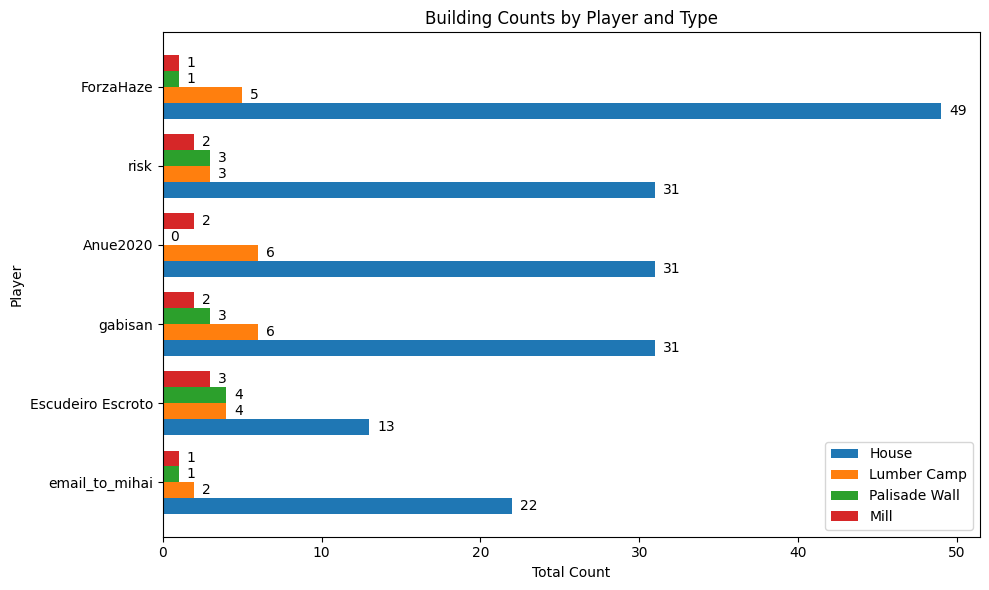

In [13]:
import matplotlib.pyplot as plt
import numpy as np

building_data = {'House': {'email_to_mihai': 22, 'Escudeiro Escroto': 13, 'gabisan': 31, 'Anue2020': 31, 'risk': 31, 'ForzaHaze': 49}, 'Lumber Camp': {'email_to_mihai': 2, 'Escudeiro Escroto': 4, 'gabisan': 6, 'Anue2020': 6, 'risk': 3, 'ForzaHaze': 5}, 'Palisade Wall': {'email_to_mihai': 1, 'Escudeiro Escroto': 4, 'gabisan': 3, 'Anue2020': 0, 'risk': 3, 'ForzaHaze': 1}, 'Mill': {'email_to_mihai': 1, 'Escudeiro Escroto': 3, 'gabisan': 2, 'Anue2020': 2, 'risk': 2, 'ForzaHaze': 1}}

all_players = list(building_data['House'].keys())
building_types = list(building_data.keys())
num_building_types = len(building_types)

bar_width = 0.8 / num_building_types
x_pos = np.arange(len(all_players))

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars and add text labels
for i, building_type in enumerate(building_types):
    values = [building_data[building_type].get(player, 0) for player in all_players]
    bars = ax.barh(x_pos + i * bar_width, values, bar_width, label=building_type)

    # Add text labels for values
    for bar, value in zip(bars, values):
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
                str(value), ha='left', va='center', color='black')

# Set labels, ticks, and legend (same as before)
ax.set_ylabel("Player")
ax.set_xlabel("Total Count")
ax.set_title("Building Counts by Player and Type")
ax.set_yticks(x_pos + bar_width * (num_building_types - 1) / 2)
ax.set_yticklabels(all_players)
ax.legend(loc='lower right')

# Adjust layout
plt.tight_layout()
plt.show()

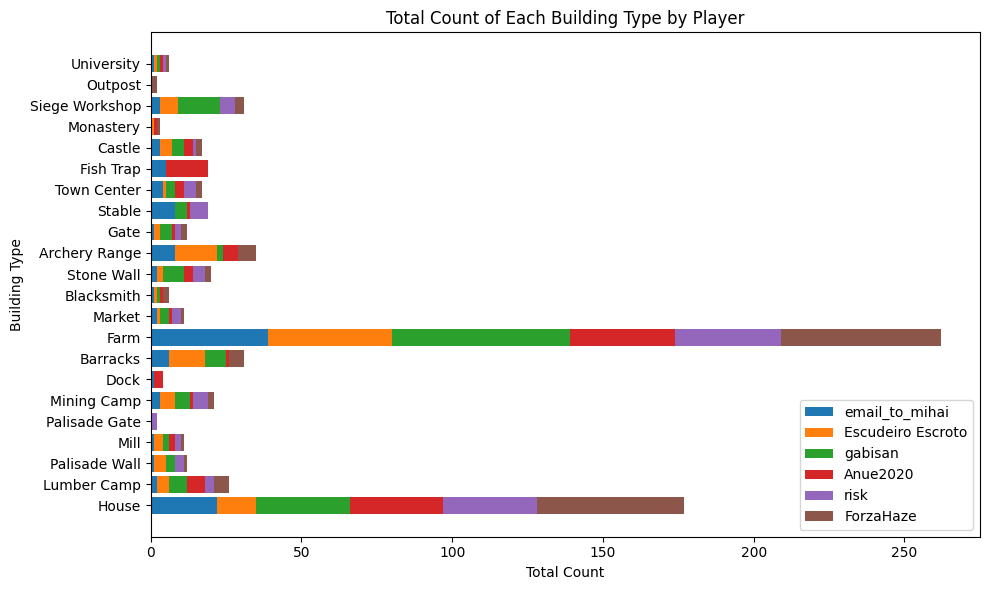

In [11]:
import matplotlib.pyplot as plt
import numpy as np

building_data = all_buildings.getValues()

# Get a list of all players and building types
all_players = list(building_data['House'].keys())
building_types = list(building_data.keys())

# Create data for stacked bar graph
player_data = {player: [building_data[building].get(player, 0) for building in building_types]
               for player in all_players}

# Create the horizontal stacked bar graph
fig, ax = plt.subplots(figsize=(10, 6))
left = np.zeros(len(building_types))  # Start from the left

for player, data in player_data.items():
    ax.barh(building_types, data, left=left, label=player)  # Use barh()
    left += data  # Update left position for stacking

ax.set_ylabel("Building Type")  # Switch labels
ax.set_xlabel("Total Count")    # Switch labels
ax.set_title("Total Count of Each Building Type by Player")
ax.legend(loc='lower right')  # Adjust legend position
plt.tight_layout()
plt.show()

## Army

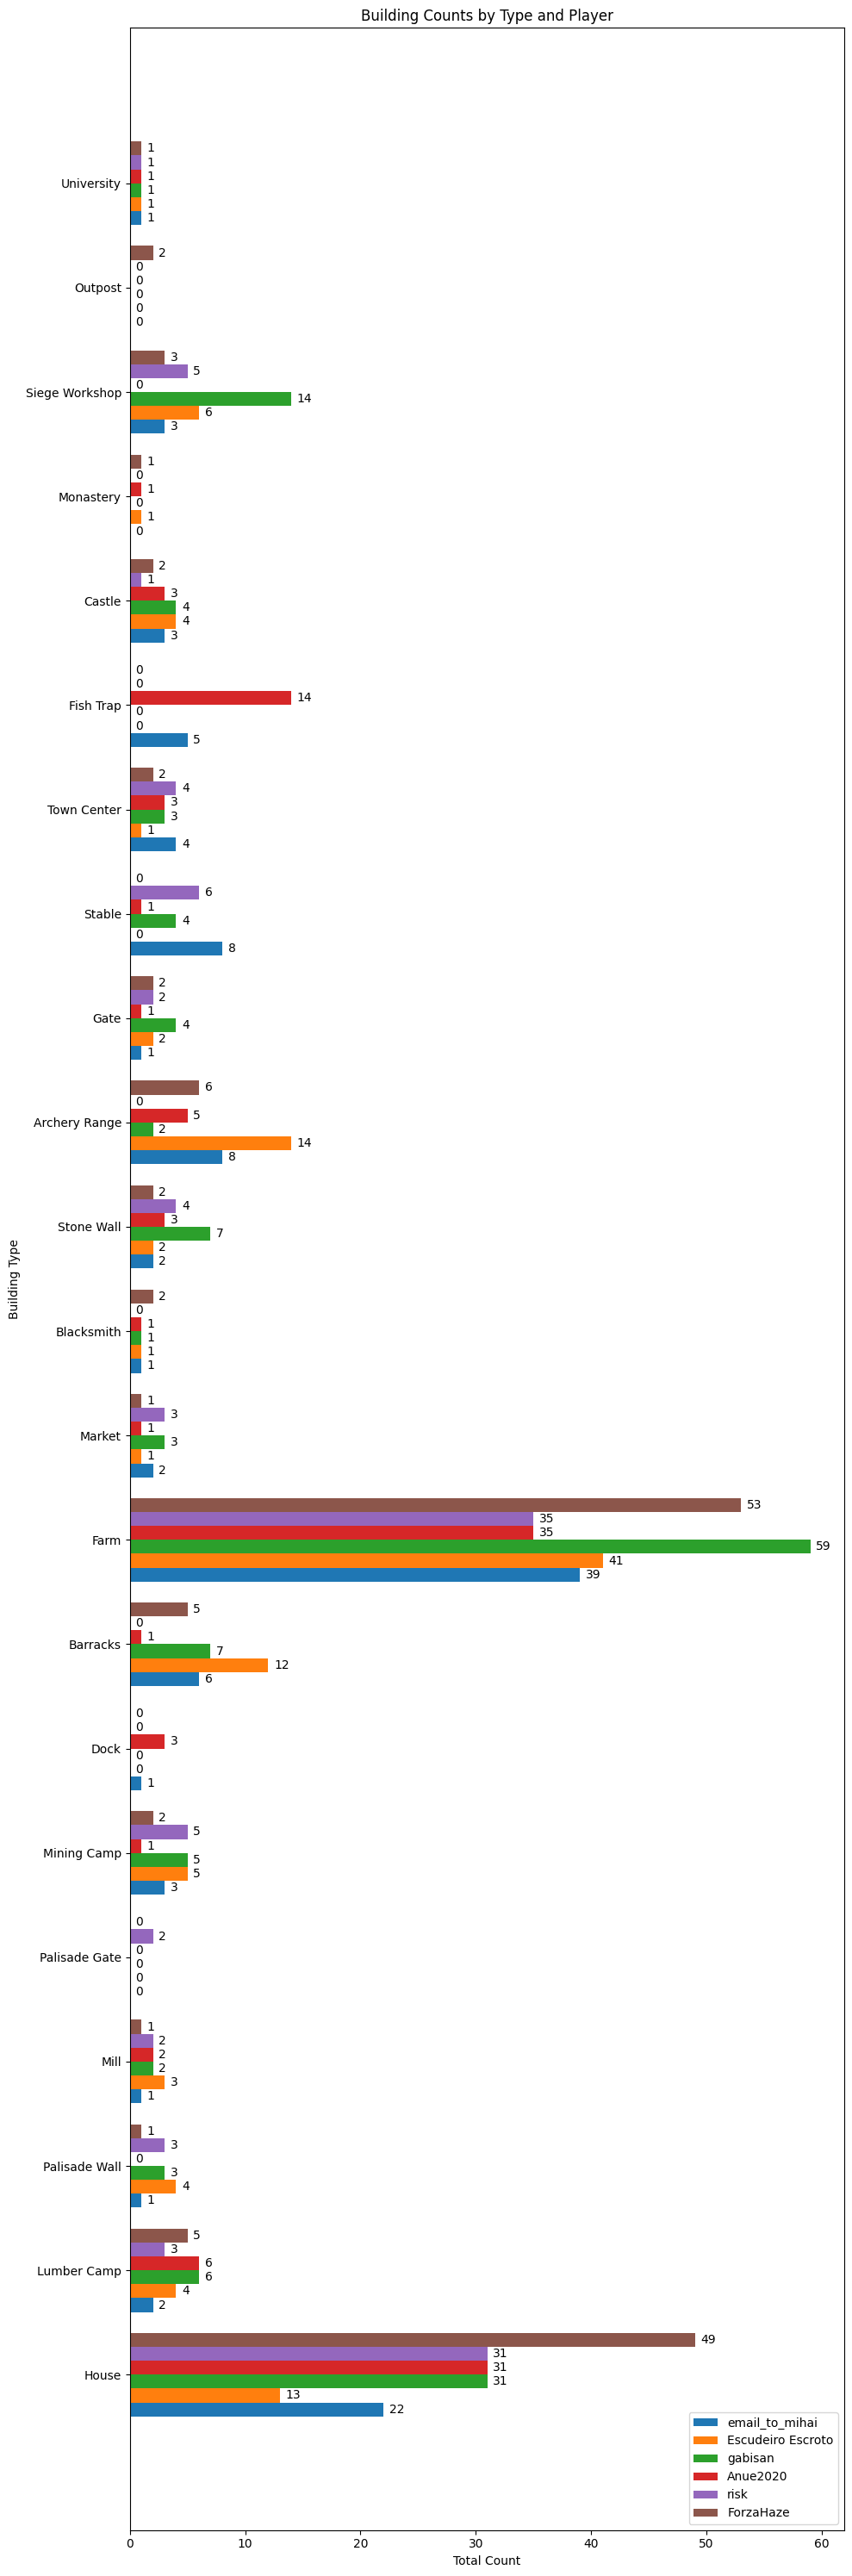

In [33]:
import matplotlib.pyplot as plt
import numpy as np

building_data = all_buildings.getValues()

all_players = list(building_data['House'].keys())
building_types = list(building_data.keys())
num_players = len(all_players)

bar_width = 0.8 / num_players  # Adjust width for spacing
y_pos = np.arange(len(building_types))  # Positions for building types on y-axis

fig, ax = plt.subplots(figsize=(10, 30))

# Create bars for each player and add text labels
for i, player in enumerate(all_players):
    values = [building_data[building_type].get(player, 0) for building_type in building_types]
    bars = ax.barh(y_pos + i * bar_width, values, bar_width, label=player)

    # Add text labels for values
    for bar, value in zip(bars, values):
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
                str(value), ha='left', va='center', color='black')

# Set labels and title
ax.set_ylabel("Building Type")
ax.set_xlabel("Total Count")
ax.set_title("Building Counts by Type and Player")

# Set y-axis ticks and labels
ax.set_yticks(y_pos + bar_width * (num_players - 1) / 2)
ax.set_yticklabels(building_types)

# Add legend
ax.legend(loc='lower right')

# Adjust layout
plt.tight_layout()

plt.savefig(f"building_counts_{game_id}.png")
#plt.show()


In [32]:
import requests
import os
from google.colab import userdata


# Save the plot as an image file

def discordMessageWithFile(content, file_path=None):
  from google.colab import userdata
  userdata.get('webhook')
  import requests
  webhook_url = userdata.get('webhook')
  if file_path:
      with open(file_path, 'rb') as f:
          files = {'file': f}
          response = requests.post(webhook_url, files=files)
  else:
      data = {"content": content}
      response = requests.post(webhook_url, json=data)
  if response.status_code == 204 or response.status_code==200:
      print("Message sent successfully!")
  else:
      print(f"Failed to send message: {response.status_code}")

# Send the image to Discord using a webhook
if new_game:
  discordMessage(f"Last game {game_id}")
  discordMessageWithFile(f"Last game: {game_id}",file_path=f"building_counts_{game_id}.png")

# ... (rest of your code) ...

Message sent successfully!
